# Knowledge Distillation

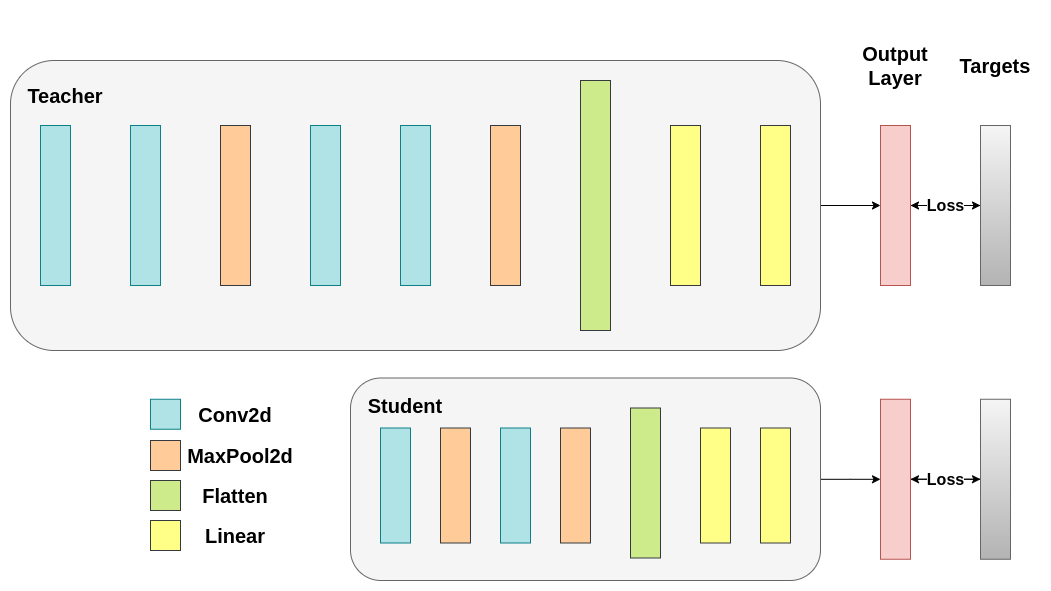

In [ ]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=a23ecfc9362107a9fab69592709712662ee79e0e32cb8bdcb0280cb10635b9dd
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from PIL import Image, ImageOps, ImageEnhance
from efficientnet_pytorch import EfficientNet
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import time
import os
import copy
from torchvision.transforms.functional import to_pil_image
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
## Load in pretrained effnet model and remove its head, replacing it with fully connected layer
## that gives 10 outputs
def get_model(model_name='efficientnet-b0'):
    model = EfficientNet.from_pretrained(model_name)
    del model._fc
    # # # use the same head as the baseline notebook.
    model._fc = nn.Linear(1280, 10)
    return model

# Teacher model

In [ ]:
teacher = get_model()
teacher.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 329MB/s]


Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [ ]:
dummy_input = torch.rand(16,3,32,32).to(device)

In [ ]:
out = teacher(dummy_input)

# MNIST DATASET

In [ ]:
train_data = datasets.MNIST('./', train=True, transform=transforms.Compose(
        [transforms.Grayscale(num_output_channels=3),transforms.Resize(32), transforms.ToTensor()]
    ), download=True)
test_data = datasets.MNIST('./', train=False, transform=transforms.Compose(
        [transforms.Grayscale(num_output_channels=3),transforms.Resize(32), transforms.ToTensor()]
    ), download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:10<00:00, 913kB/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.36MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
test_dl = DataLoader(test_data, batch_size = 128, shuffle=True)

In [ ]:
for x,y in train_dl:
  out = teacher(x.to(device))
  print(x.shape, y.shape, out.argmax(dim=1).shape)
  break

torch.Size([64, 3, 32, 32]) torch.Size([64]) torch.Size([64])


# Teacher training

In [ ]:
# loss function
loss_func = nn.CrossEntropyLoss()

# optimizer
opt = optim.Adam(teacher.parameters())

# lr scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

In [ ]:
# make directorch to save dataset
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')

# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [ ]:
# set hyper parameters
# define the training parameters
params_train = {
    'num_epochs':3,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':test_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/teacher_weights.pt',
}

createFolder('./models')

In [ ]:
teacher, loss_hist, metric_hist = train_val(teacher, params_train)

Epoch 0/2, current lr= 0.001
Copied best model weights!
train loss: 0.002544, val loss: 0.000264, accuracy: 99.00, time: 1.1067 min
----------
Epoch 1/2, current lr= 0.001
train loss: 0.000932, val loss: 0.000322, accuracy: 98.67, time: 2.1003 min
----------
Epoch 2/2, current lr= 0.001
train loss: 0.000706, val loss: 0.000292, accuracy: 98.85, time: 3.1165 min
----------


Teacher accuracy = 99.39\%

Loss = 0.000162

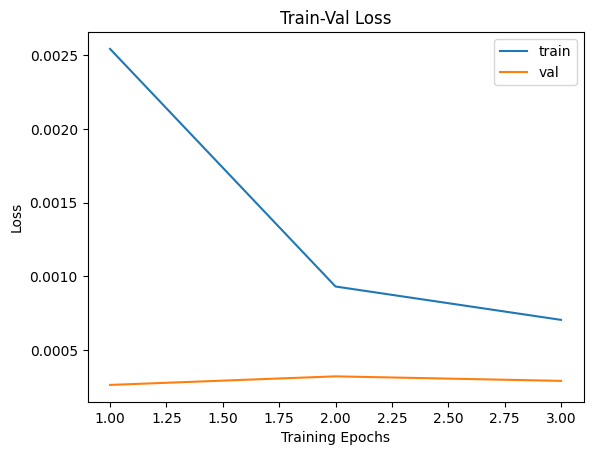

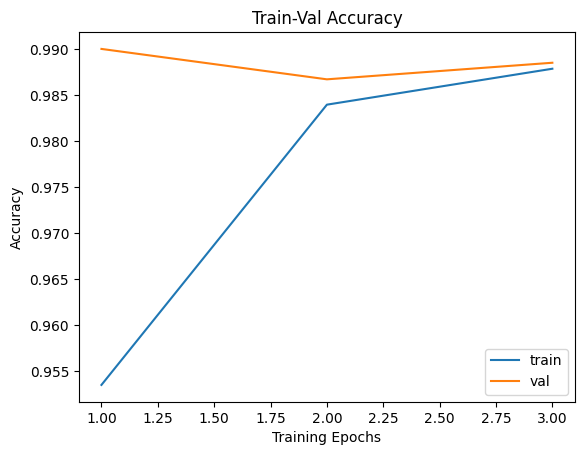

In [ ]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# Student Training

In [ ]:
class student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 800)
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800,800)
        self.bn2 = nn.BatchNorm1d(800)
        self.fc3 = nn.Linear(800,10)

    def forward(self, x):
        x = x[:,0,:,:]
        x = x.view(-1, 32*32)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
# check
x = torch.randn(16,3,32,32).to(device)
Student = student().to(device)
output = Student(x)
print(output.shape)

torch.Size([16, 10])


In [ ]:
Teacher = get_model().to(device)
# load weight
Teacher.load_state_dict(torch.load('/content/models/teacher_weights.pt'))

Student = student().to(device)

Loaded pretrained weights for efficientnet-b0


<ipython-input-17-095dda75931e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Teacher.load_state_dict(torch.load('/content/models/teacher_weights.pt'))


In [ ]:
loss_func = nn.CrossEntropyLoss()

# optimizer
opt = optim.Adam(Student.parameters())

# lr scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

In [ ]:
# set hyper parameters
# define the training parameters
params_train = {
    'num_epochs':10,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':test_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/student_weights.pt',
}


In [ ]:
Student, loss_hist, metric_hist = train_val(Student, params_train)

Epoch 0/9, current lr= 0.001
Copied best model weights!
train loss: 0.002661, val loss: 0.000677, accuracy: 97.31, time: 0.3744 min
----------
Epoch 1/9, current lr= 0.001
Copied best model weights!
train loss: 0.001324, val loss: 0.000602, accuracy: 97.49, time: 0.7284 min
----------
Epoch 2/9, current lr= 0.001
Copied best model weights!
train loss: 0.001006, val loss: 0.000510, accuracy: 98.03, time: 1.0982 min
----------
Epoch 3/9, current lr= 0.001
Copied best model weights!
train loss: 0.000796, val loss: 0.000467, accuracy: 98.08, time: 1.4662 min
----------
Epoch 4/9, current lr= 0.001
train loss: 0.000633, val loss: 0.000530, accuracy: 98.04, time: 1.8351 min
----------
Epoch 5/9, current lr= 0.001
train loss: 0.000512, val loss: 0.000482, accuracy: 98.18, time: 2.1951 min
----------
Epoch 6/9, current lr= 0.001
Copied best model weights!
train loss: 0.000436, val loss: 0.000451, accuracy: 98.29, time: 2.5656 min
----------
Epoch 7/9, current lr= 0.001
Copied best model weight

Student accuracy = 98.35\%

Loss = 0.000427

# Knowledge Distillation

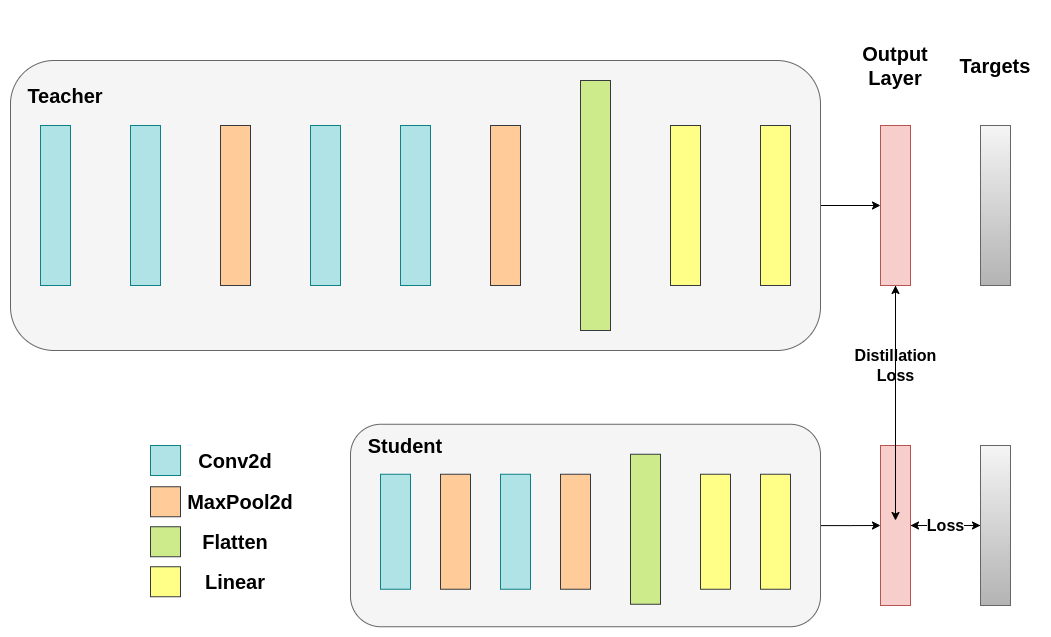

In [ ]:
# optimizer
opt = optim.Adam(Student.parameters())

# distillation
def distillation(y, labels, teacher_scores, T, alpha):
    # distillation loss + classification loss
    # y: student
    # labels: hard label
    # teacher_scores: soft label
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)

# val loss
loss_func = nn.CrossEntropyLoss()

In [ ]:
def distill_loss_batch(output, target, teacher_output, loss_fn=distillation, opt=opt):
    loss_b = loss_fn(output, target, teacher_output, T=20.0, alpha=0.7)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

In [ ]:
num_epochs= 5

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

best_loss = float('inf')
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

    # train
    Student.train()

    running_loss = 0.0
    running_metric = 0.0
    len_data = len(train_dl.dataset)

    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        output = Student(xb)
        teacher_output = Teacher(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=opt)
        running_loss += loss_b
        running_metric_b = metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # validation
    Student.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(Student, loss_func, test_dl)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)


    lr_scheduler.step(val_loss)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

Epoch 0/4, current lr= 0.001


<ipython-input-21-6254c49df788>:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)
<ipython-input-21-6254c49df788>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3369: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


train loss: 0.006790, val loss: 0.000449, accuracy: 98.23, time: 0.6856 min
----------
Epoch 1/4, current lr= 0.001
train loss: 0.004719, val loss: 0.000409, accuracy: 98.39, time: 1.3481 min
----------
Epoch 2/4, current lr= 0.001
train loss: 0.004160, val loss: 0.000404, accuracy: 98.45, time: 2.0030 min
----------
Epoch 3/4, current lr= 0.001
train loss: 0.003789, val loss: 0.000354, accuracy: 98.61, time: 2.6515 min
----------
Epoch 4/4, current lr= 0.001
train loss: 0.003676, val loss: 0.000364, accuracy: 98.47, time: 3.3032 min
----------


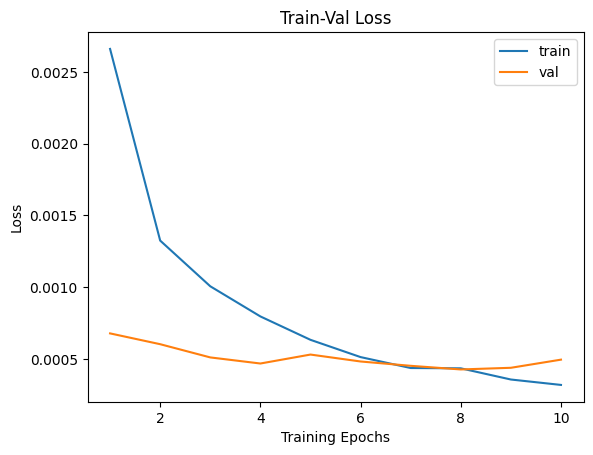

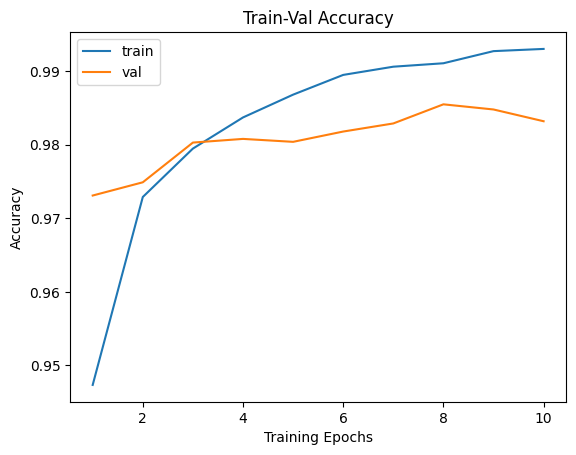

In [ ]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

Taught Student accuracy: 98.79

Loss : 0.000427

# Даалгавар: Teacher болон Student загварын дундаас нь мэдлэгийг дамжуулах замаар сургалтыг гүйцэтгэн үр дүнг лабораторийн үр дүнтэй харьцуул

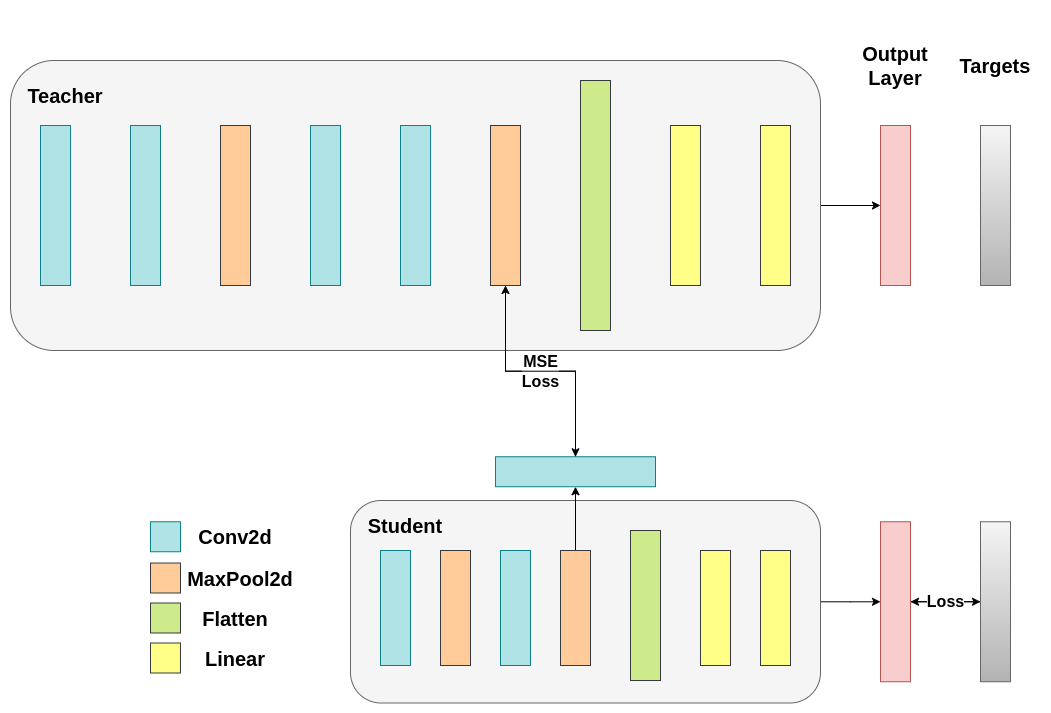

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:22<00:00, 7.45MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
teacher_model = resnet18(pretrained=True)
teacher_model.fc = nn.Linear(512, 10)
device = torch.device("cuda")
teacher_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
device = torch.device("cpu")
student_model = StudentModel().to(device)



In [ ]:
mse_loss = nn.MSELoss()
cross_entropy_loss = nn.CrossEntropyLoss()

In [ ]:
teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=0.001)
student_optimizer = optim.Adam(student_model.parameters(), lr=0.001)

In [ ]:
def train_teacher():
    teacher_model.train()
    for epoch in range(5):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            teacher_optimizer.zero_grad()
            outputs = teacher_model(inputs)
            loss = cross_entropy_loss(outputs, labels)
            loss.backward()
            teacher_optimizer.step()

            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Teacher Loss: {running_loss / len(trainloader)}')


In [ ]:
def train_student():
    teacher_model.eval()
    student_model.train()
    for epoch in range(5):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            student_optimizer.zero_grad()
            student_outputs = student_model(inputs)
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)


            loss = mse_loss(student_outputs, teacher_outputs.detach()) + \
                   cross_entropy_loss(student_outputs, labels)
            loss.backward()
            student_optimizer.step()

            running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Student Loss: {running_loss / len(trainloader)}')


In [ ]:
def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

In [ ]:
train_teacher()
evaluate(teacher_model)
train_student()
evaluate(student_model)

Epoch 1, Teacher Loss: 2.5990629592515013
Epoch 2, Teacher Loss: 2.598131844454714
Epoch 3, Teacher Loss: 2.5995140045195284
Epoch 4, Teacher Loss: 2.6011993824063664
Epoch 5, Teacher Loss: 2.5987582834785248
Accuracy: 10.76%


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

#### aaa

In [ ]:
teacher, loss_hist_teacher, metric_hist_teacher = train_val(teacher, params_train)


Epoch 0/9, current lr= 0.0001
Copied best model weights!
train loss: 0.000271, val loss: 0.000189, accuracy: 99.25, time: 0.9489 min
----------
Epoch 1/9, current lr= 0.0001
train loss: 0.000260, val loss: 0.000189, accuracy: 99.24, time: 1.8975 min
----------
Epoch 2/9, current lr= 0.0001
Copied best model weights!
train loss: 0.000254, val loss: 0.000188, accuracy: 99.25, time: 2.8917 min
----------
Epoch 3/9, current lr= 0.0001
Copied best model weights!
train loss: 0.000284, val loss: 0.000186, accuracy: 99.25, time: 3.8365 min
----------
Epoch 4/9, current lr= 0.0001
train loss: 0.000271, val loss: 0.000194, accuracy: 99.25, time: 4.7831 min
----------
Epoch 5/9, current lr= 0.0001
Copied best model weights!
train loss: 0.000237, val loss: 0.000186, accuracy: 99.25, time: 5.7284 min
----------
Epoch 6/9, current lr= 0.0001
train loss: 0.000258, val loss: 0.000188, accuracy: 99.23, time: 6.6743 min
----------
Epoch 7/9, current lr= 0.0001
train loss: 0.000252, val loss: 0.000189, a

In [ ]:
student, loss_hist_student, metric_hist_student = train_val(Student, params_train)

Epoch 0/9, current lr= 0.0001
Copied best model weights!
train loss: 0.000770, val loss: 0.000411, accuracy: 98.68, time: 0.3637 min
----------
Epoch 1/9, current lr= 0.0001
Copied best model weights!
Loading best model weights!
train loss: 0.000484, val loss: 0.000364, accuracy: 98.61, time: 0.7300 min
----------
Epoch 2/9, current lr= 1e-05
train loss: 0.000394, val loss: 0.000381, accuracy: 98.68, time: 1.0841 min
----------
Epoch 3/9, current lr= 1e-05
Copied best model weights!
train loss: 0.000368, val loss: 0.000353, accuracy: 98.72, time: 1.4428 min
----------
Epoch 4/9, current lr= 1e-05
train loss: 0.000404, val loss: 0.000357, accuracy: 98.72, time: 1.8079 min
----------
Epoch 5/9, current lr= 1e-05
Copied best model weights!
train loss: 0.000360, val loss: 0.000341, accuracy: 98.64, time: 2.1728 min
----------
Epoch 6/9, current lr= 1e-05
train loss: 0.000322, val loss: 0.000355, accuracy: 98.69, time: 2.5221 min
----------
Epoch 7/9, current lr= 1e-05
Loading best model we

In [ ]:
for xb, yb in train_dl:
    xb = xb.to(device)
    yb = yb.to(device)
    student_output = Student(xb)
    teacher_output = Teacher(xb).detach()  # Teacher's soft labels
    loss_b, metric_b = distill_loss_batch(student_output, yb, teacher_output, loss_fn=distillation, opt=opt)
    running_loss += loss_b
    running_metric += metric_b


<ipython-input-23-6254c49df788>:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)
<ipython-input-23-6254c49df788>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)


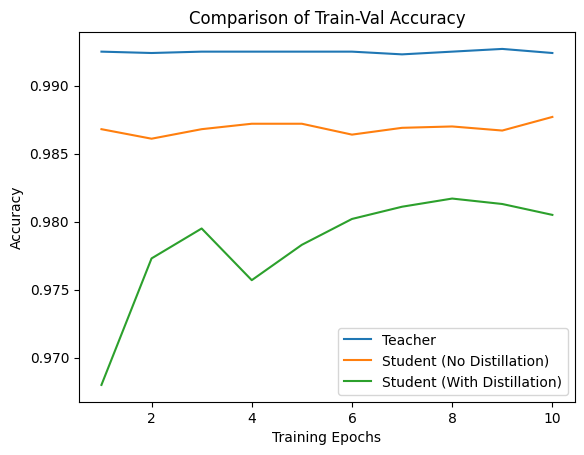

In [ ]:
plt.title('Comparison of Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist_teacher['val'], label='Teacher')
plt.plot(range(1, num_epochs+1), metric_hist_student['val'], label='Student (No Distillation)')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='Student (With Distillation)')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()


## help

Loaded pretrained weights for efficientnet-b0
torch.Size([64, 3, 32, 32]) torch.Size([64]) torch.Size([64])
Epoch 0/2, current lr= 0.001
Copied best model weights!
train loss: 0.002467, val loss: 0.000409, accuracy: 98.49, time: 0.9757 min
----------
Epoch 1/2, current lr= 0.001
Copied best model weights!
train loss: 0.000923, val loss: 0.000329, accuracy: 98.58, time: 1.9688 min
----------
Epoch 2/2, current lr= 0.001
Copied best model weights!
train loss: 0.000759, val loss: 0.000208, accuracy: 99.25, time: 2.9763 min
----------


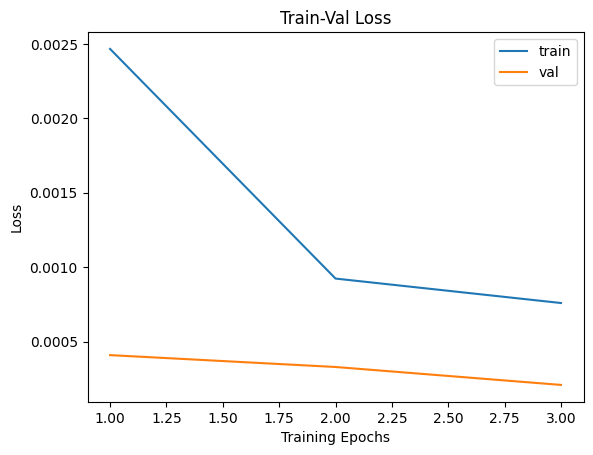

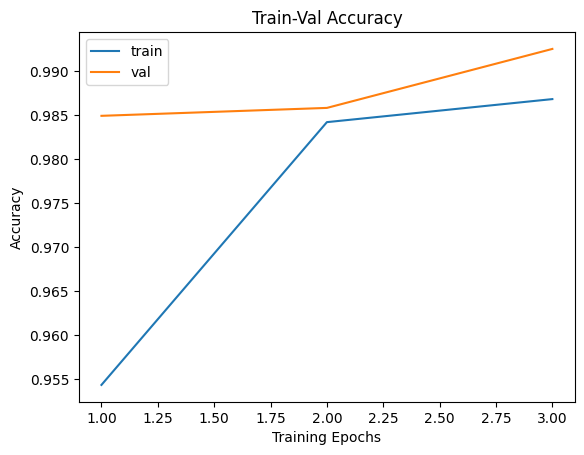

torch.Size([16, 10])
Loaded pretrained weights for efficientnet-b0
Epoch 0/9, current lr= 0.001


<ipython-input-31-23d1aa04dd52>:239: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Teacher.load_state_dict(torch.load('/content/models/teacher_weights.pt'))


Copied best model weights!
train loss: 0.002627, val loss: 0.000700, accuracy: 97.24, time: 0.3650 min
----------
Epoch 1/9, current lr= 0.001
Copied best model weights!
train loss: 0.001341, val loss: 0.000591, accuracy: 97.62, time: 0.7231 min
----------
Epoch 2/9, current lr= 0.001
Copied best model weights!
train loss: 0.000979, val loss: 0.000536, accuracy: 97.85, time: 1.0790 min
----------
Epoch 3/9, current lr= 0.001
train loss: 0.000771, val loss: 0.000557, accuracy: 97.83, time: 1.4455 min
----------
Epoch 4/9, current lr= 0.001
Copied best model weights!
train loss: 0.000632, val loss: 0.000445, accuracy: 98.15, time: 1.8108 min
----------
Epoch 5/9, current lr= 0.001
train loss: 0.000531, val loss: 0.000475, accuracy: 98.24, time: 2.1620 min
----------
Epoch 6/9, current lr= 0.001
Copied best model weights!
train loss: 0.000469, val loss: 0.000436, accuracy: 98.11, time: 2.5241 min
----------
Epoch 7/9, current lr= 0.001
train loss: 0.000364, val loss: 0.000490, accuracy: 9

<ipython-input-31-23d1aa04dd52>:276: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)
<ipython-input-31-23d1aa04dd52>:276: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)


train loss: 0.016587, val loss: 0.000627, accuracy: 97.86, time: 0.6563 min
----------
Epoch 1/4, current lr= 0.001
train loss: 0.012339, val loss: 0.000663, accuracy: 97.90, time: 1.3124 min
----------
Epoch 2/4, current lr= 0.001
train loss: 0.010817, val loss: 0.000540, accuracy: 98.10, time: 1.9612 min
----------
Epoch 3/4, current lr= 0.001
train loss: 0.010066, val loss: 0.000579, accuracy: 98.16, time: 2.6109 min
----------
Epoch 4/4, current lr= 0.001
train loss: 0.009623, val loss: 0.000454, accuracy: 98.42, time: 3.2597 min
----------


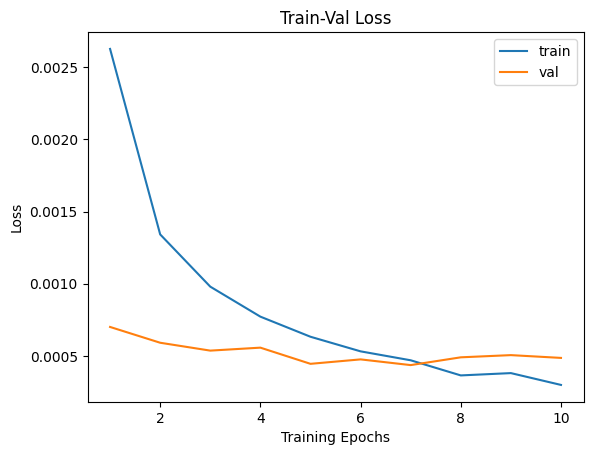

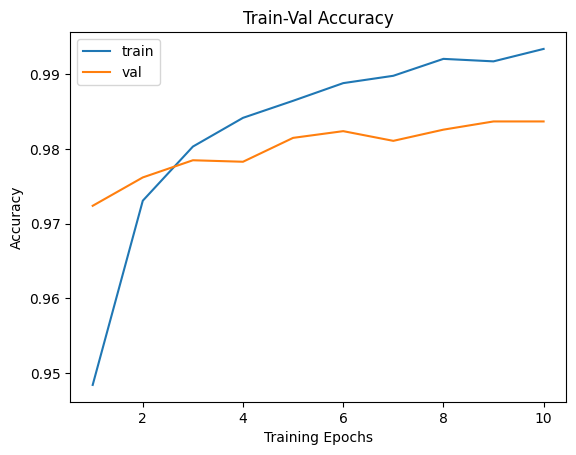

In [ ]:
!pip install efficientnet-pytorch
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from PIL import Image, ImageOps, ImageEnhance
from efficientnet_pytorch import EfficientNet
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import time
import os
import copy
from torchvision.transforms.functional import to_pil_image
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load in pretrained effnet model and remove its head, replacing it with fully connected layer
## that gives 10 outputs
def get_model(model_name='efficientnet-b0'):
    model = EfficientNet.from_pretrained(model_name)
    del model._fc
    # # # use the same head as the baseline notebook.
    model._fc = nn.Linear(1280, 10)
    return model

teacher = get_model()
teacher.to(device)

dummy_input = torch.rand(16,3,32,32).to(device)

out = teacher(dummy_input)

train_data = datasets.MNIST('./', train=True, transform=transforms.Compose(
        [transforms.Grayscale(num_output_channels=3),transforms.Resize(32), transforms.ToTensor()]
    ), download=True)
test_data = datasets.MNIST('./', train=False, transform=transforms.Compose(
        [transforms.Grayscale(num_output_channels=3),transforms.Resize(32), transforms.ToTensor()]
    ), download=True)

train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
test_dl = DataLoader(test_data, batch_size = 128, shuffle=True)

for x,y in train_dl:
  out = teacher(x.to(device))
  print(x.shape, y.shape, out.argmax(dim=1).shape)
  break

# loss function
loss_func = nn.CrossEntropyLoss()

# optimizer
opt = optim.Adam(teacher.parameters())

# lr scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

# make directorch to save dataset
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')

# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

# set hyper parameters
# define the training parameters
params_train = {
    'num_epochs':3,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':test_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/teacher_weights.pt',
}

createFolder('./models')

teacher, loss_hist, metric_hist = train_val(teacher, params_train)

num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

class student(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32, 800)
        self.bn1 = nn.BatchNorm1d(800)
        self.fc2 = nn.Linear(800,800)
        self.bn2 = nn.BatchNorm1d(800)
        self.fc3 = nn.Linear(800,10)

    def forward(self, x):
        x = x[:,0,:,:]
        x = x.view(-1, 32*32)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

# check
x = torch.randn(16,3,32,32).to(device)
Student = student().to(device)
output = Student(x)
print(output.shape)

Teacher = get_model().to(device)
# load weight
Teacher.load_state_dict(torch.load('/content/models/teacher_weights.pt'))

Student = student().to(device)

loss_func = nn.CrossEntropyLoss()

# optimizer
opt = optim.Adam(Student.parameters())

# lr scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)

# set hyper parameters
# define the training parameters
params_train = {
    'num_epochs':10,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':test_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/student_weights.pt',
}

Student, loss_hist, metric_hist = train_val(Student, params_train)

# optimizer
opt = optim.Adam(Student.parameters())

# distillation
def distillation(y, labels, teacher_scores, T, alpha):
    # distillation loss + classification loss
    # y: student
    # labels: hard label
    # teacher_scores: soft label
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 + alpha) + F.cross_entropy(y,labels) * (1.-alpha)

# val loss
loss_func = nn.CrossEntropyLoss()

def distill_loss_batch(output, target, teacher_output, loss_fn=distillation, opt=opt):
    loss_b = loss_fn(output, target, teacher_output, T=20.0, alpha=0.7)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

num_epochs= 5

loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

best_loss = float('inf')
start_time = time.time()

for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{}, current lr= {}'.format(epoch, num_epochs-1, current_lr))

    # train
    Student.train()

    running_loss = 0.0
    running_metric = 0.0
    len_data = len(train_dl.dataset)

    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)

        output = Student(xb)
        teacher_output = Teacher(xb).detach()
        loss_b, metric_b = distill_loss_batch(output, yb, teacher_output, loss_fn=distillation, opt=opt)
        running_loss += loss_b
        running_metric_b = metric_b
    train_loss = running_loss / len_data
    train_metric = running_metric / len_data

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    # validation
    Student.eval()
    with torch.no_grad():
        val_loss, val_metric = loss_epoch(Student, loss_func, test_dl)
    loss_history['val'].append(val_loss)
    metric_history['val'].append(val_metric)


    lr_scheduler.step(val_loss)

    print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
    print('-'*10)

num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot train-val accuracy
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()